In [1]:
def getdata():
  ind_mesin  = [
    [2, 0, 1, 3, 5, 4],
    [1, 2, 4, 5, 0, 3],
    [2, 3, 5, 0, 1, 4],
    [1, 0, 2, 3, 4, 5],
    [2, 1, 4, 5, 0, 3],
    [1, 3, 5, 0, 4, 2]
  ]
  job_shop = [
    [1, 3, 6, 7, 3, 6],
    [8, 5, 10, 10, 10, 4],
    [5, 4, 8, 9, 1, 7],
    [5, 5, 5, 3, 8, 9],
    [9, 3, 5, 4, 3, 1],
    [3, 3, 9, 10, 4, 1]
  ]


  jmlh_job =6
  jmlh_mesin =6
  order_mch = [[0 for _ in range(jmlh_mesin)] for _ in range(jmlh_job)]

  for i in range(1, jmlh_job + 1):
        for j in range(0, jmlh_mesin):

            order_mch[i - 1][j] = ind_mesin[i - 1][j] + 1

  return job_shop, order_mch, jmlh_job, jmlh_mesin


In [2]:
!pip install inspyred
!pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 676.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 714.4 kB/s eta 0:00:00


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chart_studio.plotly as py
import plotly.figure_factory as ff
import datetime
import time
import copy

# Asign variables

js, om, jobs, machines = getdata()
mut_select_rate=0.1
num_iteration=2000
cross_rt=0.8
mut_rt=0.2
population_size= 30
generations=machines*jobs
num_mutation_jobs=round(generations*mut_select_rate)


init = time.time()

In [4]:
'''==================== main code ==============================='''
'''----- generate initial population -----'''
Tbest=999999999999999
best_list,best_obj=[],[]
population_list=[]
makespan_record=[]
for i in range(population_size):
    nxm_random_num=list(np.random.permutation(generations)) # generate a random permutation of 0 to jobs*machines-1
    population_list.append(nxm_random_num) # add to the population_list
    for j in range(generations):
        population_list[i][j]=population_list[i][j]%jobs # convert to job number format, every job appears m times

for n in range(num_iteration):
    Tbest_now=99999999999

    '''-------- two point crossover --------'''
    parent_list=copy.deepcopy(population_list)
    offspring_list=copy.deepcopy(population_list)
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

    for m in range(int(population_size/2)):
        crossover_prob=np.random.rand()
        if cross_rt>=crossover_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]
            cutpoint=list(np.random.choice(generations, 2, replace=False))
            cutpoint.sort()

            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]


    '''----------repairment-------------'''
    for m in range(population_size):
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(jobs):
            if i in offspring_list[m]:
                count=offspring_list[m].count(i)
                pos=offspring_list[m].index(i)
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            else:
                count=0
                job_count[i]=[count,0]
            if count>machines:
                larger.append(i)
            elif count<machines:
                less.append(i)

        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>machines:
                for d in range(len(less)):
                    if job_count[less[d]][0]<machines:
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        job_count[less[d]][0]=job_count[less[d]][0]+1
                    if job_count[chg_job][0]==machines:
                        break

    '''--------mutatuon--------'''
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mut_rt >= mutation_prob:
            m_chg=list(np.random.choice(generations, num_mutation_jobs, replace=False)) # chooses the position to mutation
            t_value_last=offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement

            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position


    '''--------fitness value(calculate makespan)-------------'''
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) # parent and offspring chromosomes combination
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(jobs)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(machines)]
        m_count={key:0 for key in m_keys}

        for i in total_chromosome[m]:
            gen_t=int(js[i][key_count[i]])
            gen_m=int(om[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t

            m_count[gen_m]=m_count[gen_m]+gen_t

            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]

            key_count[i]=key_count[i]+1

        makespan=max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)
        total_fitness=total_fitness+chrom_fitness[m]


    '''----------selection(roulette wheel approach)----------'''
    pk,qk=[],[]

    for i in range(population_size*2):
        pk.append(chrom_fitness[i]/total_fitness)
    for i in range(population_size*2):
        cumulative=0
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)

    selection_rand=[np.random.rand() for i in range(population_size)]

    for i in range(population_size):
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break
    '''----------comparison----------'''
    for i in range(population_size*2):
        if chrom_fit[i]<Tbest_now:
            Tbest_now=chrom_fit[i]
            sequence_now=copy.deepcopy(total_chromosome[i])
    if Tbest_now<=Tbest:
        Tbest=Tbest_now
        sequence_best=copy.deepcopy(sequence_now)

    makespan_record.append(Tbest)

Optimal sequence [2, 0, 1, 0, 1, 3, 2, 5, 3, 2, 5, 5, 1, 0, 4, 1, 3, 4, 2, 3, 5, 4, 3, 2, 5, 1, 4, 4, 0, 5, 1, 4, 0, 2, 3, 0]
the elapsed time:38.87518906593323


Text(0.5, 0, 'generation')

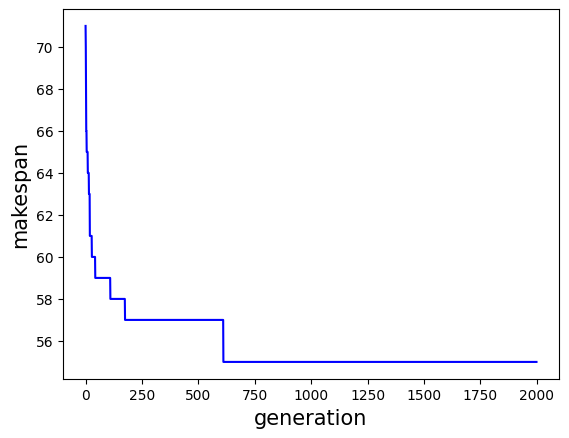

In [10]:
print("Optimal sequence",sequence_best)
print('the elapsed time:%s'% (time.time() - init))


plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)